In [ ]:
!pip install biopython==1.77

In [1]:
import os
import sys
import csv
import random
import numpy as np
import pandas as pd
from decimal import *
from Bio import SeqIO
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *

## Load Data

<b>Load DNA Sequences dataset</b>

In [2]:
load_dna_seq = []

for folder_item in os.listdir("DNA_Sequences"):
    for filename in os.listdir("DNA_Sequences/" + folder_item):
        path = "DNA_Sequences/" + folder_item + "/" + filename
        sequences = []
        seq_IDs = []
        for record in SeqIO.parse(path, "fasta"):
            sequences.append(record.seq)
            seq_IDs.append(record.id)
        
        load_dna_seq.append([filename, str(sequences[0]), folder_item])

origin_dna_df = pd.DataFrame(load_dna_seq, columns=["GenBank ID (filename)", "DNA Sequences", "Virus name"])
origin_dna_df

,GenBank ID (filename),DNA Sequences,Virus name
0,KP271018.1.fasta,AAGAAGAATTTTTAGGATCTTTTGTGTGCGAATAACTATGAGGAAG...,Ebola
1,MG572231.1.fasta,AATTTTTAGGATCTTTTGTGTGCGAATAACTATGAGGAAGATTAAT...,Ebola
2,MG572234.1.fasta,GGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGA...,Ebola
3,MH481611.2.fasta,CTTTTGTGTGCGAATAACTATGAGGAAGATTAATAATTTTCCTCTC...,Ebola
4,MK007329.1.fasta,AAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGAATAACTATG...,Ebola
...,...,...,...
75,MH916806.1.fasta,CAGACTGCGACAGTTCGAGTTTGAAGCGAAAGCTAGCAACAGTATC...,Zika
76,MK241417.1.fasta,GACAGTTCGAGTTTGAAGCGAAAGCTAGCAACAGTATCAACAGGTT...,Zika
77,MN100039.1.fasta,GTGTGAATCAGACTGCGACAGTTCGAGTTTGAAGCGAAAGCTAGCA...,Zika
78,MN124090.1.fasta,TGTGAATCAGACTGCGACAGTTCGAGTTTGAAGCGAAAGCTAGCAA...,Zika


# Feature Extraction

### N-mers Frequency

In [3]:
# N-mers Frequency function
def n_mers(Text, n):
    freq = {}
    l=len(Text)
    for i in range (l-n+1):
        Pattern = Text[i:i+n]
        if Pattern not in freq:
            freq[Pattern] = 1 # if a pattern found is not already  in the dictionary freq{}, it is assigned a value of 1 and added to the list
        else:
            freq[Pattern] +=1 # however, if the pattern is already in the dictionary, its value should go up by 1 (so if it has been found, it is initially given a pattern of 1, and then this adds another 1 if it is found again
    return dict(sorted(freq.items()))

In [4]:
nmers_result = []

for folder_item in os.listdir("DNA_Sequences"):
    for filename in os.listdir("DNA_Sequences/" + folder_item):
        path = "DNA_Sequences/" + folder_item + "/" + filename
        sequences = []
        seq_IDs = []
        print(f"Opening: {folder_item}/{filename}")
        for record in SeqIO.parse(path, "fasta"):
            sequences.append(record.seq)
            seq_IDs.append(record.id)
        
        result = n_mers(str(sequences[0]), 3)
        result.update({"GenBank ID": filename, "Virus name": folder_item})
        nmers_result.append(result)

Opening: Ebola/KP271018.1.fasta
Opening: Ebola/MG572231.1.fasta
Opening: Ebola/MG572234.1.fasta
Opening: Ebola/MH481611.2.fasta
Opening: Ebola/MK007329.1.fasta
Opening: Ebola/MK007332.1.fasta
Opening: Ebola/MK007334.1.fasta
Opening: Ebola/MK007335.1.fasta
Opening: Ebola/MK007337.1.fasta
Opening: Ebola/MK007339.1.fasta
Opening: Ebola/MK007340.1.fasta
Opening: Ebola/MK007343.1.fasta
Opening: Ebola/MK007344.1.fasta
Opening: Ebola/MK088515.1.fasta
Opening: Ebola/MK731986.1.fasta
Opening: Ebola/MK731989.1.fasta
Opening: Ebola/MK731992.1.fasta
Opening: Ebola/MK731993.1.fasta
Opening: Ebola/MK731994.1.fasta
Opening: Ebola/MW345251.1.fasta
Opening: MERS-CoV/KF958702.1.fasta
Opening: MERS-CoV/KT806047.1.fasta
Opening: MERS-CoV/KU710265.1.fasta
Opening: MERS-CoV/KX034096.1.fasta
Opening: MERS-CoV/KX034099.1.fasta
Opening: MERS-CoV/KX034100.1.fasta
Opening: MERS-CoV/MF000457.1.fasta
Opening: MERS-CoV/MF000459.1.fasta
Opening: MERS-CoV/MF000460.1.fasta
Opening: MERS-CoV/MG757605.1.fasta
Opening: M

In [5]:
dna_ordered_list = ["AAA", "AAC", "AAT", "AAG", "ACA", "ACC", "ACT", "ACG", "ATA", "ATC",
                    "ATT", "ATG", "AGA", "AGC", "AGT", "AGG", "CAA", "CAC", "CAT", "CAG",
                    "CCA", "CCC", "CCT", "CCG", "CTA", "CTC", "CTT", "CTG", "CGA", "CGC",
                    "CGT", "CGG", "GAA", "GAC", "GAT", "GAG", "GCA", "GCC", "GCT", "GCG",
                    "GTA", "GTC", "GTT", "GTG", "GGA", "GGC", "GGT", "GGG", "TAA", "TAC",
                    "TAT", "TAG", "TCA", "TCC", "TCT", "TCG", "TTA", "TTC", "TTG", "TGA",
                    "TGC", "TGT", "TGG", "TTT"]

In [6]:
nmers_df = pd.DataFrame(nmers_result, columns=["GenBank ID"] + dna_ordered_list + ["Virus name"])
nmers_df

,GenBank ID,AAA,AAC,AAT,AAG,ACA,ACC,ACT,ACG,ATA,...,TCG,TTA,TTC,TTG,TGA,TGC,TGT,TGG,TTT,Virus name
0,KP271018.1.fasta,617,417,527,409,499,278,319,134,356,...,138,401,331,378,428,246,241,257,464,Ebola
1,MG572231.1.fasta,627,416,530,404,495,276,324,129,364,...,137,396,336,376,426,255,249,262,449,Ebola
2,MG572234.1.fasta,631,416,530,407,498,276,324,129,364,...,137,396,338,377,426,255,252,262,454,Ebola
3,MH481611.2.fasta,617,406,537,406,494,273,321,134,356,...,135,401,335,378,427,256,241,259,458,Ebola
4,MK007329.1.fasta,623,417,537,400,503,267,324,136,352,...,134,395,334,383,425,250,250,262,469,Ebola
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,MH916806.1.fasta,237,161,126,278,233,145,157,84,105,...,58,67,111,205,223,170,162,389,107,Zika
76,MK241417.1.fasta,236,159,127,279,233,145,153,83,105,...,58,66,108,205,223,166,163,390,109,Zika
77,MN100039.1.fasta,244,162,131,280,234,146,160,85,106,...,60,66,115,208,225,166,165,393,110,Zika
78,MN124090.1.fasta,242,162,129,280,234,146,160,85,105,...,60,66,115,208,227,165,166,393,110,Zika


In [7]:
# save table for qualification
nmers_df.to_csv("N-mers Extraction.csv")

# Label mapping

In [8]:
label_mapping = pd.factorize(nmers_df['Virus name'])
label_mapping

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64),
 Index(['Ebola', 'MERS-CoV', 'SARS-CoV-2', 'Zika'], dtype='object'))

In [9]:
print(label_mapping[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [10]:
target_names = list(label_mapping[1])
target_names

['Ebola', 'MERS-CoV', 'SARS-CoV-2', 'Zika']

## Define x and y

In [11]:
# X
nmers_df = nmers_df.drop("GenBank ID", axis=1)
nmers_df = nmers_df.drop("Virus name", axis=1)
nmers_df = nmers_df.fillna(value=0)

In [12]:
# y
y = label_mapping[0]

# Splitting Data and Cross Validation

<b>Splitting data into: [60% Training] and [40% for Val & Tests]</b>

In [13]:
from sklearn.model_selection import train_test_split
x_train_nmers, x_val_nmers, y_train_nmers, y_val_nmers = train_test_split(nmers_df, y, train_size=0.6, stratify=y, random_state=0)

In [14]:
x_train_nmers

,AAA,AAC,AAT,AAG,ACA,ACC,ACT,ACG,ATA,ATC,...,TCT,TCG,TTA,TTC,TTG,TGA,TGC,TGT,TGG,TTT
4,623,417,537,400,503,267,324,136,352,391,...,326,134,395,334,383,425,250,250,262,469
73,234,161,127,281,232,147,161,87,106,137,...,135,59,64,114,209,226,167,163,392,109
74,237,162,126,277,232,145,156,84,105,135,...,137,58,67,110,205,224,169,162,389,107
55,894,613,766,580,804,368,672,161,476,339,...,539,113,877,518,823,631,545,858,552,1009
63,235,161,126,279,232,144,162,84,106,135,...,134,57,67,113,206,222,166,164,387,108
53,897,607,760,580,799,369,677,167,478,341,...,542,113,875,515,816,627,545,859,550,1004
1,627,416,530,404,495,276,324,129,364,371,...,310,137,396,336,376,426,255,249,262,449
39,597,449,625,523,572,352,638,204,478,346,...,668,186,791,581,846,613,630,876,585,880
13,623,406,539,406,495,273,321,134,356,385,...,326,135,400,337,379,428,256,241,259,464
44,923,615,761,580,809,375,675,164,471,339,...,541,112,877,516,819,630,547,859,555,1007


In [15]:
print("Train sets:\n")

for num in np.unique(y_train_nmers):
    print(f"Class: {target_names[num]} (Label: {num})\nCount: {np.unique(y_train_nmers, return_counts=True)[1][num]}")

print("\nTotal count on Train sets:", len(y_train_nmers))

Train sets:

Class: Ebola (Label: 0)
Count: 12
Class: MERS-CoV (Label: 1)
Count: 12
Class: SARS-CoV-2 (Label: 2)
Count: 12
Class: Zika (Label: 3)
Count: 12

Total count on Train sets: 48


<b>Splitting again into: [20% Val] and [20% for Tests] of total portions</b>

In [16]:
x_val_nmers, x_test_nmers, y_val_nmers, y_test_nmers = train_test_split(x_val_nmers,
                                                                        y_val_nmers,
                                                                        train_size=0.5,
                                                                        stratify=y_val_nmers,
                                                                        random_state=0)

In [17]:
x_val_nmers

,AAA,AAC,AAT,AAG,ACA,ACC,ACT,ACG,ATA,ATC,...,TCT,TCG,TTA,TTC,TTG,TGA,TGC,TGT,TGG,TTT
28,602,449,623,523,575,345,636,206,478,347,...,676,191,792,583,844,611,619,878,582,884
66,241,162,130,279,235,146,161,83,107,139,...,134,58,64,112,207,227,169,165,391,110
27,602,449,623,524,575,345,635,206,478,346,...,673,190,792,581,843,611,618,878,582,884
34,627,448,622,524,576,343,640,201,484,348,...,678,190,795,585,848,618,623,882,581,895
54,892,606,755,580,799,369,676,166,475,339,...,540,112,872,512,815,627,543,854,549,998
75,237,161,126,278,233,145,157,84,105,135,...,137,58,67,111,205,223,170,162,389,107
35,584,450,621,523,573,346,638,205,480,344,...,673,192,791,583,844,612,619,879,584,886
58,894,608,764,578,801,369,669,163,477,339,...,538,113,873,516,823,629,544,858,554,1004
47,894,607,759,581,801,369,676,166,475,338,...,539,112,874,513,815,627,544,857,550,1001
69,241,162,129,279,236,146,161,82,105,137,...,134,57,65,112,207,227,169,164,390,110


In [18]:
x_test_nmers

,AAA,AAC,AAT,AAG,ACA,ACC,ACT,ACG,ATA,ATC,...,TCT,TCG,TTA,TTC,TTG,TGA,TGC,TGT,TGG,TTT
41,891,615,761,579,808,373,676,164,472,340,...,540,112,878,516,818,630,547,859,554,1010
59,893,610,762,578,804,369,670,165,474,337,...,536,114,873,516,821,629,543,858,553,1005
0,617,417,527,409,499,278,319,134,356,389,...,317,138,401,331,378,428,246,241,257,464
29,597,450,624,522,574,347,638,205,481,347,...,673,189,794,584,848,616,622,881,583,884
25,597,449,625,524,575,346,638,204,481,346,...,675,190,795,585,846,616,620,882,585,886
61,241,163,129,279,235,148,163,87,107,139,...,132,59,66,114,207,226,164,167,391,109
56,888,610,755,577,806,370,675,164,468,336,...,540,109,873,514,818,629,543,856,553,1004
65,241,162,129,279,234,145,161,83,106,138,...,134,57,64,111,207,227,169,164,390,109
64,237,161,126,276,234,144,162,84,104,135,...,133,56,66,113,207,222,169,162,388,110
68,240,162,129,278,235,144,160,81,106,137,...,134,57,65,111,207,225,169,164,389,109


In [19]:
print("Validation sets:\n")

for num in np.unique(y_val_nmers):
    print(f"Class: {target_names[num]} (Label: {num})\nCount: {np.unique(y_val_nmers, return_counts=True)[1][num]}")

print("\nTotal count on Test sets:", len(y_val_nmers))

Validation sets:

Class: Ebola (Label: 0)
Count: 4
Class: MERS-CoV (Label: 1)
Count: 4
Class: SARS-CoV-2 (Label: 2)
Count: 4
Class: Zika (Label: 3)
Count: 4

Total count on Test sets: 16


In [20]:
print("Test sets:\n")

for num in np.unique(y_test_nmers):
    print(f"Class: {target_names[num]} (Label: {num})\nCount: {np.unique(y_test_nmers, return_counts=True)[1][num]}")

print("\nTotal count on Test sets:", len(y_test_nmers))

Test sets:

Class: Ebola (Label: 0)
Count: 4
Class: MERS-CoV (Label: 1)
Count: 4
Class: SARS-CoV-2 (Label: 2)
Count: 4
Class: Zika (Label: 3)
Count: 4

Total count on Test sets: 16


In [21]:
y_train_nmers

array([0, 3, 3, 2, 3, 2, 0, 1, 0, 2, 0, 2, 2, 3, 2, 0, 3, 1, 1, 3, 2, 0,
       0, 1, 1, 2, 1, 1, 2, 1, 2, 3, 3, 1, 3, 3, 0, 3, 0, 0, 0, 1, 3, 1,
       2, 1, 0, 2], dtype=int64)

In [22]:
y_val_nmers

array([1, 3, 1, 1, 2, 3, 1, 2, 2, 3, 0, 2, 0, 0, 0, 3], dtype=int64)

In [23]:
y_test_nmers

array([2, 2, 0, 1, 1, 3, 2, 3, 3, 3, 0, 0, 1, 1, 2, 0], dtype=int64)

<b>Import Evaluation Metrics</b>

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Model: Bidirectional GRU

### Model Design

In [25]:
inputs = tf.keras.Input(name='input_layer', shape=(64,1)) # shape must equal to pad_length

# BiGRU
m = Bidirectional(GRU(64, activation='tanh', return_sequences=True))(inputs)
m = Bidirectional(GRU(16, activation='tanh'))(m)

# Fully Connected
m = Dense(16, activation='relu', name='fully_connected')(m)

# output layers
outputs = Dense(4, activation='softmax', name='output_layers')(m)

model = tf.keras.Model(inputs, outputs)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64, 128)          25728     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               14016     
 nal)                                                            
                                                                 
 fully_connected (Dense)     (None, 16)                528       
                                                                 
 output_layers (Dense)       (None, 4)                 68        
                                                                 
Total params: 40,340
Trainable params: 40,340
Non-trainable p

### Start Training and Evaluate

In [28]:
train = model.fit(x_train_nmers, y_train_nmers,
                    epochs=100,
                    validation_data=(x_val_nmers, y_val_nmers),
                    verbose=1)

Epoch 1/100
2/2 [==============================] - 7s 1s/step - loss: 1.4489 - accuracy: 0.2500 - val_loss: 1.3656 - val_accuracy: 0.2500
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 1.3670 - accuracy: 0.3542 - val_loss: 1.3282 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 78ms/step - loss: 1.3212 - accuracy: 0.4375 - val_loss: 1.3062 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 78ms/step - loss: 1.3033 - accuracy: 0.5625 - val_loss: 1.2846 - val_accuracy: 0.7500
Epoch 5/100
2/2 [==============================] - 0s 78ms/step - loss: 1.2804 - accuracy: 0.7500 - val_loss: 1.2546 - val_accuracy: 0.7500
Epoch 6/100
2/2 [==============================] - 0s 78ms/step - loss: 1.2524 - accuracy: 0.7500 - val_loss: 1.2355 - val_accuracy: 0.7500
Epoch 7/100
2/2 [==============================] - 0s 78ms/step - loss: 1.2345 - accuracy: 0.7500 - val_loss: 1.2151 - val_accuracy: 0.7500
Epoch 8/100
2/2 [=====

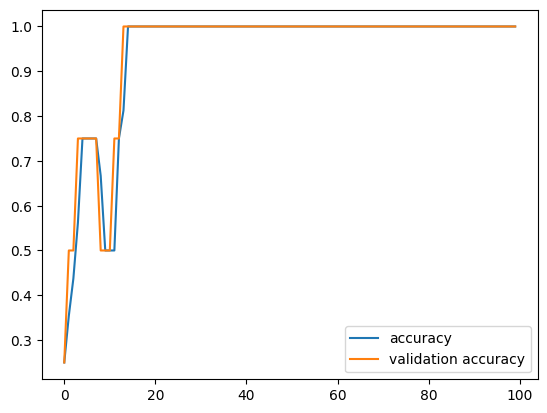

In [29]:
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.legend(['accuracy','validation accuracy'])

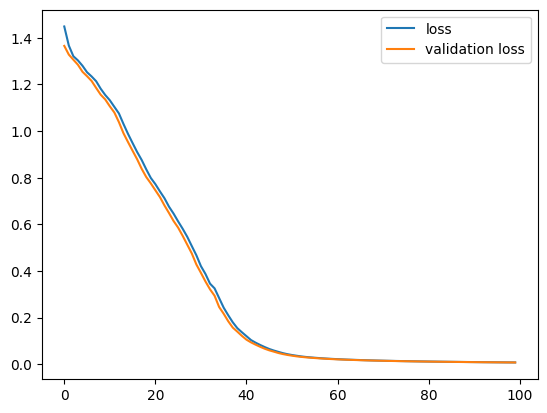

In [30]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.legend(['loss','validation loss'])

In [31]:
print("Model Evaluate:")
results = model.evaluate(np.array(x_test_nmers), y_test_nmers, verbose=1)

print()
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Model Evaluate:
1/1 [==============================] - 0s 31ms/step - loss: 0.0071 - accuracy: 1.0000

Test Loss: 0.007123916409909725
Test Accuracy: 1.0


In [32]:
y_pred = model.predict(np.array(x_test_nmers))

pred = []
for result in np.round(y_pred):
    pred.append(np.argmax(result)) # convert one-hot result to integer

pred = np.array(pred)

print("Actual:   ", y_test_nmers)
print("Predicted:", pred)

Actual:    [2 2 0 1 1 3 2 3 3 3 0 0 1 1 2 0]
Predicted: [2 2 0 1 1 3 2 3 3 3 0 0 1 1 2 0]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test_nmers, pred, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

       Ebola       1.00      1.00      1.00         4
    MERS-CoV       1.00      1.00      1.00         4
  SARS-CoV-2       1.00      1.00      1.00         4
        Zika       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



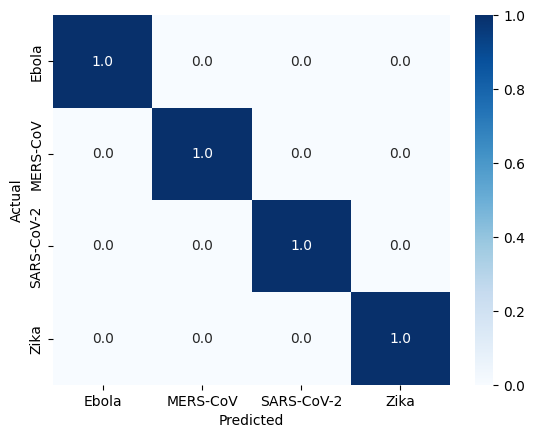

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = pd.DataFrame(confusion_matrix(y_test_nmers, pred) * 1/4, columns=target_names, index=target_names)
sns.heatmap(cf_matrix, annot=True, vmin=0, fmt='.1f', cbar=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Save Model

In [ ]:
model.save("model.h5")